In [1]:
#导入一些必要的包
import os
import random
import paddle 
from paddle import nn
from paddle import optimizer as optim 
from paddle import fluid

#import paddle.vision.datasets as dset
#import paddle.vision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation 

from tqdm import tqdm
from util.model import GeluSigGenerator,GeluSigGenerator,Generator,GeluGenerator,Generator256,SELUGenerator,HybridGenerator,NewHybridGenerator

import matplotlib.pyplot as plt

from util.config import BATCH_SIZE, INPUT_SIZE, MAX_VAL
OUTPUT_SIZE = 256
#将numpy拉展为list
def flatten(irregular_matrix) -> list:
    """ Allows flattening a matrix of nested iterables where the specific type
        and shape of each iterable is not necessarily the same. Returns
        the individual elements of the original nested iterable in a single
        flat list.

        Note that this operation's implementation is rather slow, and should
        be avoided unless necessary.

        :param irregular_matrix: a nested iterable with irregular dimensions
    """
    flattened_list = []
    try:
        for element in irregular_matrix:
            flattened_list.extend(flatten(element))
        return flattened_list
    except TypeError:
        return irregular_matrix

#将整数写入文件filename中，以8 asscii的格式
def write_numbers_to_ascii_file(values, filename: str):
    """ Produces an ASCII output text file containing hexadecimal representations
        of each number produces by the generator.

        :param values: list or numpy array values produced by generator
        :param filename: name of file to write output into
    """
    # create directory structure to file if not exists
    if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
    # flatten and encode in hex
    values = flatten(values)
    values = [format(np.uint8(i), 'x') for i in values]
    # write hex values to ASCII file
    with open(filename, 'w+') as file:
        for hex_val in tqdm(values, 'Writing to file ... '):
            file.write(str(hex_val) + "\n")


#将filename中的asscii格式，转化为16位的二进制格式;一个文件对一个文件转化
def write_ascii_to_bin_file(filename):
    new_filename = filename[:-4] + '_dieharder.txt'
    # for each file, open and create edited
    with open(filename) as file, open(new_filename, 'w') as new_file:
        data = file.readlines()
        for number in data:
            new_file.write(format(int(number,16), '08b'))

#将filenames为list类型，将多个finame转化为一个二进制文件，注意是多个对一个
def mul_write_ascii_to_bin_file(filenames,new_filename):
    with open(new_filename,'a+') as new_file:
        for filename in filenames:
        # for each file, open and create edited
            with open(filename) as file:
                data = file.readlines()
                for number in data:
                    new_file.write(format(int(number, 16), '08b'))

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
def reference_distribution_np(batch_size, seq_length, max_val) -> np.ndarray:
    """ Returns a batch of inputs sampled from the reference distribution, i.e.
    from the random uniform distribution. """
    return np.random.uniform(size=[batch_size, seq_length], low=0, high=max_val)


# 定义一个函数将float转化为8位二进制序列
def int_to_bin(x):
    # 检查x是否在0到255之间
    if x < 0 or x > 255:
        raise ValueError("x must be between 0 and 255")
    # 将x四舍五入为整数
    #x_int = round(x)
    # 将x_int转化为二进制字符串，并去掉前缀"0b"
    bin_str = bin(x)[2:]
    # 在左边补足0，使长度为8
    bin_str = bin_str.zfill(8)
    # 返回二进制字符串
    return bin_str

def get_rand_from_mantissa(manti):
    #从尾数中获取从小数点后第二位开始的3位数字。如果不够3位，则补0
    t_str = str(manti).split('.')[1][4:7]
    length = len(t_str)
    if length <3:
        for i in range(3-length):
            t_str = ''.join([t_str,'0'])

    return int(t_str)%256



#产生从0到max_val的随机数，类型为paddle.Tensor,大小为[batch_size, seq_length]，其中floor为向下取整
def reference_distribution_paddle(batch_size, seq_length, max_val) -> paddle.Tensor:
    #return fluid.layers.uniform_random(shape=[batch_size, seq_length], min=-0.5*max_val, max=0.5*max_val).floor()
    return fluid.layers.uniform_random(shape=[batch_size, seq_length], min=0., max=max_val).floor()

In [3]:
# 定义一个函数将float转化为8位二进制序列
def float_to_bin(x):
    # 检查x是否在0到255之间
    if x < 0 or x > 255:
        raise ValueError("x must be between 0 and 255")
    # 将x四舍五入为整数
    x_int = round(x)
    # 将x_int转化为二进制字符串，并去掉前缀"0b"
    bin_str = bin(x_int)[2:]
    # 在左边补足0，使长度为8
    bin_str = bin_str.zfill(8)
    # 返回二进制字符串
    return bin_str

#将双精度的浮点数，转换为二进制表示，通常有23位
def decimal_to_binary(a, n=16,j=0,k=8):
    b = np.zeros(n+1, dtype=int)
    for i in range(1, n+1, 1):
        x = 2**(-1*i)
        if (a - x) >= 0:
            b[i] = 1
            a -= x
    b = b[1::]
    x = [str(i) for i in b]
    b_str = "".join(x)

    return b_str[j:k]

# 定义一个函数将二进制序列转化为字符串，不分隔每个元素
def bin_to_str(x):
    # 将数组转化为列表
    x_list = x.tolist()
    # 用空格连接列表中的每个元素
    x_str = "".join(x_list)
    # 返回字符串
    return x_str

def write_bin_str(bin_arr, filename):
    bin_arr = bin_arr.flatten()

    # 使用函数将二进制序列转化为字符串
    bin_str = bin_to_str(bin_arr)

    # 打开一个txt文件，如果不存在则创建一个
    with open(filename,'w') as f:
        f.write(bin_str)

# 定义一个函数将两个数组水平相接
def h_join(arr1, arr2):
    # 检查两个数组是否有相同的形状
    if arr1.shape != arr2.shape:
        raise ValueError("arr1 and arr2 must have the same shape")
    # 获取数组的行数和列数
    m, n = arr1.shape
    # 创建一个空的结果数组，形状为原来的两倍
    result = np.empty((m, 2 * n),dtype=np.dtype('<U8'))
    # 使用嵌套循环将两个数组的元素交叉填充到结果数组中
    for i in range(m):
        for j in range(n):
            # 将第一个数组的第i行第j列元素放在结果数组的第i行第j列位置
            result[i, j] = arr1[i, j]
            # 将第二个数组的第i行第j列元素放在结果数组的第i行第j+n列位置
            result[ i, j + n] = arr2[i, j]
    # 返回结果数组
    return result


# 定义一个函数将两个数组垂直相接
def v_join(arr1, arr2):
    # 检查两个数组是否有相同的形状
    if arr1.shape != arr2.shape:
        raise ValueError("arr1 and arr2 must have the same shape")
    # 获取数组的行数和列数
    m, n = arr1.shape
    # 创建一个空的结果数组，形状为原来的两倍
    result = np.empty((m * 2, n),dtype=np.dtype('<U8'))
    # 使用嵌套循环将两个数组的元素交叉填充到结果数组中
    for i in range(m):
        for j in range(n):
            # 将第一个数组的第i行第j列元素放在结果数组的第i行第j列位置
            result[i, j] = arr1[i, j]
            # 将第二个数组的第i行第j列元素放在结果数组的第i行第j+n列位置
            result[ m + i, j] = arr2[i, j]
    # 返回结果数组
    return result


# 定义一个函数将两个数组交叉相接
def cross_join(arr1, arr2):
    # 检查两个数组是否有相同的形状
    if arr1.shape != arr2.shape:
        raise ValueError("arr1 and arr2 must have the same shape")
    # 获取数组的行数和列数
    m, n = arr1.shape
    # 创建一个空的结果数组，形状为原来的两倍
    result = np.empty((m, 2 * n),dtype=np.dtype('<U8'))
    # 使用嵌套循环将两个数组的元素交叉填充到结果数组中
    for i in range(m):
        for j in range(n):
            # 将第一个数组的第i行第j列元素放在结果数组的第2i行第2j列位置
            result[i, 2 * j] = arr1[i, j]
            # 将第二个数组的第i行第j列元素放在结果数组的第2i行第2j+1列位置
            result[ i, 2 * j + 1] = arr2[i, j]
    # 返回结果数组
    return result


# 定义一个函数将两个数组交叉相接
def reverse_join(arr1, arr2):
    # 检查两个数组是否有相同的形状
    if arr1.shape != arr2.shape:
        raise ValueError("arr1 and arr2 must have the same shape")
    # 获取数组的行数和列数
    m, n = arr1.shape
    # 创建一个空的结果数组，形状为原来的两倍
    result = np.empty((m, 2 * n),dtype=np.dtype('<U8'))
    # 使用嵌套循环将两个数组的元素交叉填充到结果数组中
    for i in range(m):
        for j in range(n):
            # 将第一个数组的第i行第j列元素放在结果数组的第2i行第2j列位置
            result[i, j] = arr1[i, j]
            # 将第二个数组的第i行第j列元素放在结果数组的第2i行第2j+1列位置
            result[ i, j + n] = arr2[m-1-i, n-j-1]
    # 返回结果数组
    return result


# 定义一个函数将二进制序列转化为字符串，不分隔每个元素
def bin_to_str(x):
    # 将数组转化为列表
    x_list = x.tolist()
    # 用空格连接列表中的每个元素
    x_str = "".join(x_list)
    # 返回字符串
    return x_str

def write_bin_str(bin_arr, filename):
    bin_arr = bin_arr.flatten()

    # 使用函数将二进制序列转化为字符串
    bin_str = bin_to_str(bin_arr)

    # 打开一个txt文件，如果不存在则创建一个
    with open(filename,'w') as f:
        f.write(bin_str)


In [4]:
from util import mylayer
INPUT_SIZE = 32
# Generator Code


# Generator Code

class GeluGenerator(nn.Layer):
    def __init__(self, ):
        super(GeluGenerator, self).__init__()

        self.gen1 = nn.Sequential(

            nn.Linear(INPUT_SIZE,100),
            nn.GELU(),

            #第二个
            nn.Linear(100,200),
            nn.GELU(),

            #第三个
            nn.Linear(200,INPUT_SIZE),
            mylayer.Mod(),

        )

        self.gen = nn.Sequential(

            #第一个input is Z,
            nn.Linear(INPUT_SIZE,128),
            #nn.BatchNorm(100),
            nn.ReLU(),

            #第二个
            nn.Linear(128,256),
            #nn.BatchNorm(200),
            nn.ReLU(),


           #第三个
            nn.Linear(256,512),
            #nn.BatchNorm(400),
            nn.ReLU(),
            
            nn.Linear(512,1024),
            #nn.BatchNorm(400),
            nn.ReLU(),

            #第四个
            nn.Linear(1024,OUTPUT_SIZE),
            #nn.BatchNorm(OUTPUT_SIZE),
            mylayer.Mod(),

        )

    def forward(self, x):
        
        #x = self.gen1(x)
        x = self.gen(x)

        return x



netG = GeluGenerator()

print(netG)

GeluGenerator(
  (gen1): Sequential(
    (0): Linear(in_features=32, out_features=100, dtype=float32)
    (1): GELU(approximate=False)
    (2): Linear(in_features=100, out_features=200, dtype=float32)
    (3): GELU(approximate=False)
    (4): Linear(in_features=200, out_features=32, dtype=float32)
    (5): Mod(max_val=256.0,name=)
  )
  (gen): Sequential(
    (0): Linear(in_features=32, out_features=128, dtype=float32)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, dtype=float32)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, dtype=float32)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, dtype=float32)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=256, dtype=float32)
    (9): Mod(max_val=256.0,name=)
  )
)


In [5]:
#inputparam = 'work/gelu8generator-steps3000.params'

inputparam = 'work/ttnewnewbce0generator-steps10000.params'
#inputparam = 'work/gelu/149-4c-bce0generator-steps10000.params'
#inputparam = 'work/hybrid/2141bce0generator-steps10000.params'
layer_state_dict = paddle.load(inputparam)
netG.set_state_dict(layer_state_dict)
# 将该模型及其所有子层设置为预测模式
netG.eval()



In [10]:
test_sample = reference_distribution_paddle(256, INPUT_SIZE, MAX_VAL) 

predicts = netG(test_sample)


eval_out = predicts.floor().numpy()

print(eval_out.shape)


print(eval_out)
np.savetxt('output.txt', eval_out, fmt='%d', delimiter=',')

#image1=eval_out[:256,:]
#image2 = eval_out[256:512,:]

(256, 256)
[[ 49. 216.  41. ... 124.  60. 171.]
 [ 54.  37. 226. ...  54. 198.  32.]
 [138. 218.   9. ... 168. 129.  21.]
 ...
 [  9.  40.  46. ... 189. 237. 125.]
 [208. 254.  74. ...   2. 126. 195.]
 [ 75. 106.   7. ... 113. 154. 131.]]


In [22]:
import numpy as np
import hashlib
'''使用SHA256将32个整数list，不断hash，直到生成256*32矩阵'''
# 创建一个空的256x32的NumPy矩阵

def hash_with_salt(data, salt):
    '''data,salt is bytes'''
    # 将salt与数据进行组合
    data_with_salt = data + salt

    # 计算SHA-256哈希值
    sha256_hash = hashlib.sha256(data_with_salt).digest()

    return sha256_hash

salt = "somesalt".encode()
matrix = np.empty((256, 32), dtype=np.uint8)

random_int = np.random.randint(0, 256, size=32, dtype=np.uint8)
matrix[0] = random_int

# 生成256个32个8位二进制长度的整数
for i in range(255):
    # 生成一个随机的32个8位二进制长度的整数
    before_int = matrix[i]
    # 将整数转换为字节串
    byte_string = before_int.tobytes()
    
    # 使用SHA256哈希函数计算哈希值
    #hash_value = hashlib.sha256(byte_string).digest()
    hash_value = hash_with_salt(byte_string, salt)
    
    # 将哈希值转换为32个8位二进制长度的整数
    hash_int = np.frombuffer(hash_value, dtype=np.uint8)
    
    # 将哈希结果存储到矩阵中
    matrix[i+1] = hash_int

In [25]:
test_sample = paddle.to_tensor(matrix,dtype = 'float32')
print(matrix.shape,test_sample.shape)
predicts = netG(test_sample)

eval_out = predicts.floor().numpy()
print(eval_out.shape)

print(eval_out)

(256, 32) [256, 32]
(256, 256)
[[223.   3. 244. ...   0.   4. 239.]
 [236. 250. 245. ...  10.  16. 234.]
 [228. 248. 239. ...   6.  10. 235.]
 ...
 [228. 252. 238. ...   7.  16. 236.]
 [250. 244. 253. ...   8.  16. 238.]
 [239. 248. 243. ...   7.  11. 240.]]


In [26]:
key = eval_out.astype(np.uint8)
key.shape

(256, 256)

In [29]:
import numpy as np
from PIL import Image
'''图片加密演示'''
def encrypt(eval_out, original_path,encrypt_path,decrypt_path):
    # 读取原始图片
    original_image = Image.open(original_path)

    original_array = np.array(original_image)
    print(original_array)
    # 随机生成密钥矩阵
    #key = np.random.randint(0, 256, size=(512, 512), dtype=np.uint8)

    key = eval_out.astype(np.uint8)

    # 加密过程：将原始图片与密钥矩阵进行异或运算
    encrypted_array = np.bitwise_xor(original_array, key)

    # 生成密文图片
    encrypted_image = Image.fromarray(encrypted_array)
    encrypted_image.save(encrypt_path)

    # 解密过程：将密文图片与密钥矩阵进行异或运算
    decrypted_array = np.bitwise_xor(encrypted_array, key)

    # 生成解密后的图片
    decrypted_image = Image.fromarray(decrypted_array)
    decrypted_image.save(decrypt_path)

pimage = 'lena256.png'
path = 'misc/'
original_path = 'misc/' + pimage
encrypt_path = 'misc/' + "encrypt_image_"+pimage
decrypt_path = 'misc/' + "decrypt_image_"+pimage
encrypt(original_path,encrypt_path,decrypt_path)


(256, 256)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


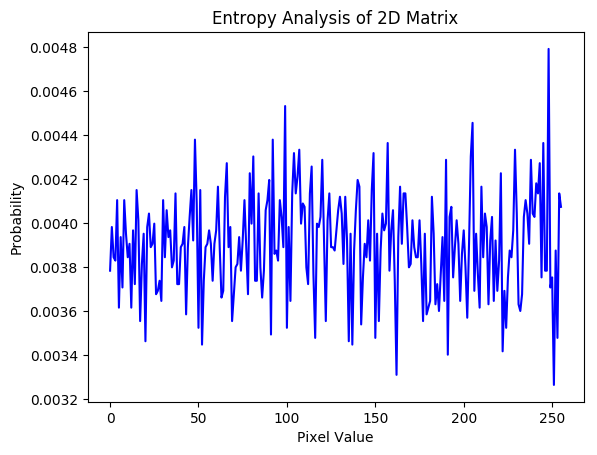

In [11]:
# 计算熵
hist, _ = np.histogram(eval_out.flatten(), bins=256, range=(0, 256))
probabilities = hist / np.sum(hist)
entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))

# 绘制熵分布图
plt.plot(probabilities, color='blue')
plt.xlabel('Pixel Value')
plt.ylabel('Probability')
plt.title('Entropy Analysis of 2D Matrix')
#plt.ylim(0, 1.)  # 设置纵坐标范围为0-600
plt.show()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


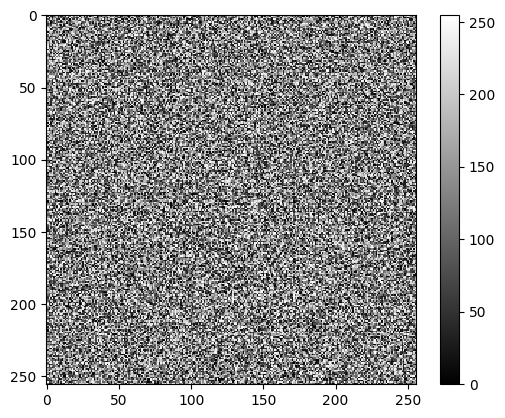

In [12]:
# 绘制数据分布图
plt.imshow(eval_out, cmap='gray')
plt.colorbar()
#plt.title('Data Distribution of 2D Matrix')

plt.savefig('./dis.png')

plt.show()


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


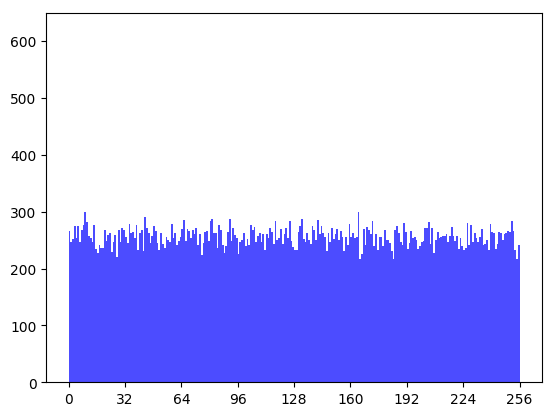

In [14]:
# 将二维矩阵展平为一维数组
flatten_matrix = eval_out.flatten()

# 绘制直方图
plt.hist(flatten_matrix, bins=256, range=(0, 256), color='blue', alpha=0.7)
#plt.xlabel('Pixel Value')
#plt.ylabel('Frequency')
#plt.title('Histogram of 2D Matrix')
plt.xticks(np.arange(0, 257, 32))
plt.ylim(0, 650)  # 设置纵坐标范围为0-600
plt.savefig('./histogram.png')

plt.show()


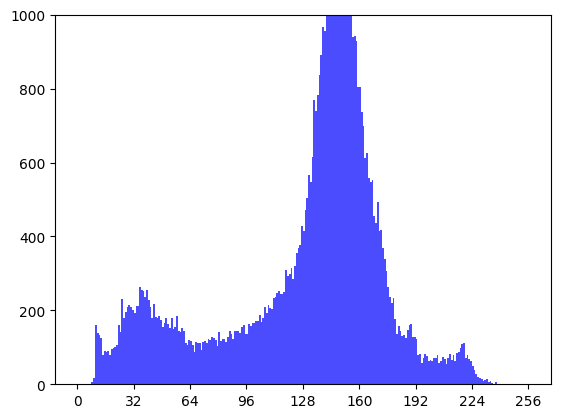

In [51]:
from PIL import Image
import matplotlib.pyplot as plt

# 读取PNG图片
image = Image.open('misc/decrypt_image_boat256.png')
original_array = np.array(image).flatten()
# 绘制直方图
plt.hist(original_array, bins=256, range=(0, 256), color='blue', alpha=0.7)
#plt.xlabel('Pixel Value')
#plt.ylabel('Frequency')
#plt.title('Histogram of 2D Matrix')
plt.xticks(np.arange(0, 257, 32))
plt.ylim(0, 1000)  # 设置纵坐标范围为0-600
plt.savefig('misc/decrypt_image_boat256histogram.png')

plt.show()



In [11]:
unique_elements, counts = np.unique(eval_out, return_counts=True)

print("各个数字的个数：")
for i in range(len(unique_elements)):
    print(f"{unique_elements[i]}: {counts[i]}")

各个数字的个数：
0.0: 256
1.0: 256
2.0: 265
3.0: 252
4.0: 254
5.0: 253
6.0: 254
7.0: 256
8.0: 276
9.0: 253
10.0: 277
11.0: 264
12.0: 220
13.0: 227
14.0: 291
15.0: 276
16.0: 261
17.0: 266
18.0: 252
19.0: 273
20.0: 246
21.0: 267
22.0: 264
23.0: 238
24.0: 257
25.0: 261
26.0: 237
27.0: 234
28.0: 266
29.0: 268
30.0: 256
31.0: 253
32.0: 248
33.0: 260
34.0: 223
35.0: 266
36.0: 244
37.0: 260
38.0: 243
39.0: 252
40.0: 250
41.0: 261
42.0: 284
43.0: 237
44.0: 278
45.0: 260
46.0: 243
47.0: 274
48.0: 277
49.0: 262
50.0: 253
51.0: 256
52.0: 234
53.0: 259
54.0: 258
55.0: 269
56.0: 242
57.0: 259
58.0: 257
59.0: 292
60.0: 265
61.0: 276
62.0: 274
63.0: 266
64.0: 252
65.0: 257
66.0: 246
67.0: 240
68.0: 289
69.0: 250
70.0: 251
71.0: 267
72.0: 243
73.0: 247
74.0: 235
75.0: 273
76.0: 272
77.0: 253
78.0: 234
79.0: 240
80.0: 245
81.0: 247
82.0: 244
83.0: 284
84.0: 252
85.0: 252
86.0: 250
87.0: 248
88.0: 253
89.0: 259
90.0: 241
91.0: 260
92.0: 233
93.0: 241
94.0: 266
95.0: 233
96.0: 263
97.0: 246
98.0: 282
99.0: 252
1

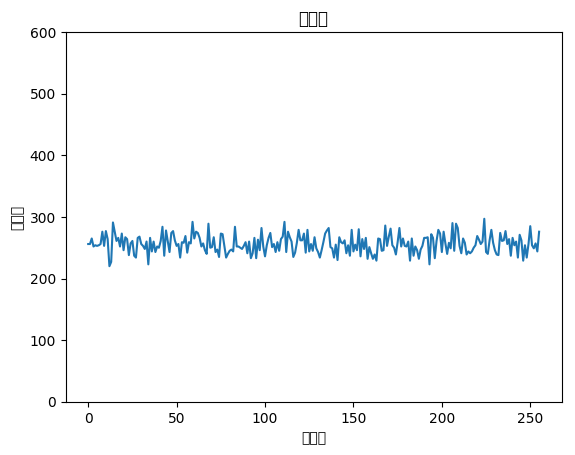

In [12]:
import matplotlib.pyplot as plt

plt.plot(unique_elements, counts)
plt.xlabel('横坐标')
plt.ylabel('纵坐标')
plt.title('折线图')
plt.ylim(0, 600)  # 设置纵坐标范围为0-600
plt.show()

In [18]:
import cv2 
cv2.imwrite('image/image.jpeg', eval_out)

#cv2.imwrite('image/image1.jpeg', image1)
#cv2.imwrite('image/image2.jpeg', image2)

True

In [19]:
import cv2
import numpy as np
from collections import Counter

# 读取灰度图像
image = cv2.imread('image/image.jpeg', cv2.IMREAD_GRAYSCALE)

# 统计各像素值的个数
pixel_counts = Counter(image.flatten())

# 按照从大到小排序
sorted_pixel_counts = sorted(pixel_counts.items(), key=lambda x: x[1], reverse=True)

# 打印结果
for pixel, count in sorted_pixel_counts:
    print(f"像素值 {pixel} 的个数为：{count}")

像素值 255 的个数为：411
像素值 8 的个数为：398
像素值 5 的个数为：395
像素值 6 的个数为：377
像素值 246 的个数为：377
像素值 12 的个数为：377
像素值 249 的个数为：375
像素值 4 的个数为：373
像素值 0 的个数为：373
像素值 7 的个数为：367
像素值 11 的个数为：365
像素值 242 的个数为：363
像素值 9 的个数为：359
像素值 241 的个数为：359
像素值 21 的个数为：358
像素值 247 的个数为：354
像素值 16 的个数为：350
像素值 13 的个数为：349
像素值 243 的个数为：349
像素值 250 的个数为：349
像素值 244 的个数为：348
像素值 245 的个数为：347
像素值 10 的个数为：347
像素值 24 的个数为：345
像素值 22 的个数为：344
像素值 248 的个数为：344
像素值 238 的个数为：343
像素值 15 的个数为：340
像素值 3 的个数为：336
像素值 231 的个数为：336
像素值 251 的个数为：335
像素值 235 的个数为：335
像素值 17 的个数为：332
像素值 236 的个数为：331
像素值 14 的个数为：331
像素值 23 的个数为：327
像素值 20 的个数为：320
像素值 228 的个数为：320
像素值 232 的个数为：316
像素值 252 的个数为：315
像素值 26 的个数为：314
像素值 30 的个数为：313
像素值 237 的个数为：313
像素值 27 的个数为：313
像素值 19 的个数为：313
像素值 253 的个数为：310
像素值 18 的个数为：308
像素值 240 的个数为：307
像素值 220 的个数为：307
像素值 233 的个数为：306
像素值 239 的个数为：304
像素值 2 的个数为：304
像素值 230 的个数为：303
像素值 229 的个数为：302
像素值 31 的个数为：302
像素值 223 的个数为：295
像素值 36 的个数为：295
像素值 221 的个数为：294
像素值 33 的个数为：291
像素值 234 的个数为：291
像素值 29 的个数为：290
像素值

In [14]:
unique_elements, counts = np.unique(eval_out, return_counts=True)

print("各个数字的个数：")
for i in range(len(unique_elements)):
    print(f"{unique_elements[i]}: {counts[i]}")

各个数字的个数：
0.0: 260
1.0: 270
2.0: 263
3.0: 258
4.0: 250
5.0: 253
6.0: 252
7.0: 252
8.0: 244
9.0: 243
10.0: 251
11.0: 274
12.0: 264
13.0: 255
14.0: 224
15.0: 256
16.0: 273
17.0: 255
18.0: 268
19.0: 235
20.0: 253
21.0: 253
22.0: 277
23.0: 262
24.0: 275
25.0: 254
26.0: 242
27.0: 242
28.0: 258
29.0: 274
30.0: 252
31.0: 261
32.0: 268
33.0: 266
34.0: 259
35.0: 245
36.0: 272
37.0: 243
38.0: 281
39.0: 263
40.0: 244
41.0: 275
42.0: 250
43.0: 274
44.0: 298
45.0: 263
46.0: 238
47.0: 274
48.0: 249
49.0: 259
50.0: 253
51.0: 283
52.0: 244
53.0: 266
54.0: 249
55.0: 254
56.0: 256
57.0: 259
58.0: 273
59.0: 246
60.0: 269
61.0: 253
62.0: 281
63.0: 248
64.0: 246
65.0: 248
66.0: 281
67.0: 249
68.0: 257
69.0: 274
70.0: 255
71.0: 241
72.0: 247
73.0: 240
74.0: 281
75.0: 257
76.0: 252
77.0: 253
78.0: 248
79.0: 246
80.0: 264
81.0: 268
82.0: 270
83.0: 245
84.0: 253
85.0: 252
86.0: 213
87.0: 241
88.0: 234
89.0: 259
90.0: 276
91.0: 252
92.0: 241
93.0: 244
94.0: 233
95.0: 256
96.0: 264
97.0: 289
98.0: 250
99.0: 265
1

In [86]:
import paddle

x = paddle.rand((2, 2, 2, 3))
print(x)
layer_norm = paddle.nn.LayerNorm(x.shape[1:])
layer_norm_out = layer_norm(x)

print(layer_norm_out)

Tensor(shape=[2, 2, 2, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[[[0.84955752, 0.41515720, 0.95664960],
          [0.09408272, 0.57000691, 0.71377832]],

         [[0.20409913, 0.62425381, 0.28298843],
          [0.56603360, 0.37955657, 0.82042474]]],


        [[[0.25926527, 0.06192482, 0.55068463],
          [0.46157649, 0.02777155, 0.82109535]],

         [[0.25430787, 0.96027690, 0.51608443],
          [0.35723326, 0.47666541, 0.71695888]]]])
Tensor(shape=[2, 2, 2, 3], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[[[ 1.19545567, -0.48058128,  1.60864663],
          [-1.71937573,  0.11687186,  0.67158186]],

         [[-1.29490197,  0.32617146, -0.99052507],
          [ 0.10154174, -0.61793840,  1.08305335]]],


        [[[-0.71722794, -1.43915784,  0.34887046],
          [ 0.02288646, -1.56410050,  1.33811295]],

         [[-0.73536360,  1.84728050,  0.22229266],
          [-0.35883200,  0.07808619,  0.95715094]]]])


In [84]:
# scale as a float32 number
import paddle

data = paddle.randn(shape=[2,3], dtype='float32')
print(data)
res = paddle.scale(data, scale=2.0, bias=0.0)
print(res)

Tensor(shape=[2, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[ 0.04454485,  0.03783139, -0.85108566],
        [-2.12620592, -1.15098929, -1.19476497]])
Tensor(shape=[2, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[ 0.08908970,  0.07566278, -1.70217133],
        [-4.25241184, -2.30197859, -2.38952994]])


In [20]:
BATCH_SIZE = 512
test_sample = paddle.zeros([1, 32]) 
test_sample[0,31]=231
test_sample[0,30]=7
print(test_sample)

for step_t in range(1000):
    filepath = round(step_t / 100)

    predicts = netG(test_sample)

    #将随机数输出转化为numpy类型
    eval_out=predicts.numpy()

    #整数部分
    number_int = np.floor(eval_out)
    # 使用向量化操作将数组中的每个元素应用函数
    number_arr = np.vectorize(float_to_bin)(number_int)
    write_bin_str(number_arr,'data/ss'+str(filepath)+'/bin_zhengshu'+str(step_t)+'.txt')

    test_sample = x1

    print(step_t,filepath)

Tensor(shape=[1, 32], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 7.  , 231.]])


NameError: name 'x1' is not defined

In [15]:
BATCH_SIZE = 512
for step_t in range(1000):
    filepath = round(step_t / 100)

    test_sample = reference_distribution_paddle(BATCH_SIZE, INPUT_SIZE, MAX_VAL) 
    predicts = netG(test_sample)

    #将随机数输出转化为numpy类型
    eval_out=predicts.numpy()

    #整数部分
    number_int = np.floor(eval_out)
    # 使用向量化操作将数组中的每个元素应用函数
    number_arr = np.vectorize(float_to_bin)(number_int)
    write_bin_str(number_arr,'mydata/ss'+str(filepath)+'/bin_zhengshu'+str(step_t)+'.txt')

    print(step_t,filepath)

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 2
151 2
152 2
153 2
154 2
155 2
156 2
157 2
158 2
159 2
160 2
161 2
162 2
163 2
164 2
165 2
166 2
167 2
168 2
169 2
170 2
171 2
172 2
173 2
174 2
175 2
176 2
177 2
178 2
179 2
180 2
181 2
182 2
183 2
184 2
185 

In [11]:
eval_out = predicts.floor().numpy()
eval_out.shape

(512, 256)

(512, 256)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

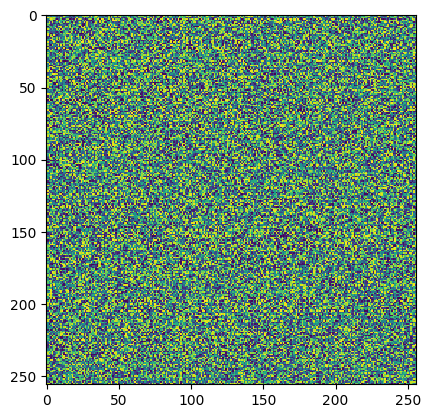

In [12]:
eval_out = predicts.floor().numpy()
print(eval_out.shape)
image1=eval_out[:256,:]
image2 = eval_out[256:512,:]
plt.imshow(image1)
plt.savefig("image/image1new.eps", format='eps', dpi=300)

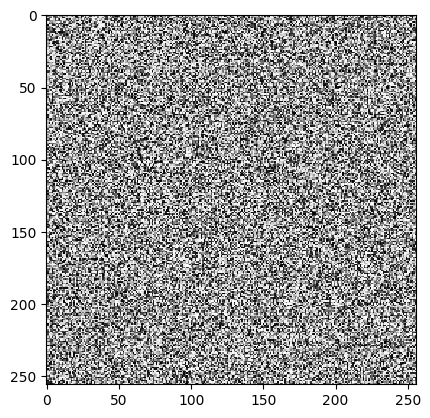

In [13]:
plt.imshow(image2,cmap='Greys_r')

In [14]:
import cv2 
cv2.imwrite('image/image1.jpeg', image1)
cv2.imwrite('image/image2.jpeg', image2)

True

255 551
254 515
253 528
252 517





In [15]:
print(np.sum( eval_out>251))

2610


In [10]:

BATCH_SIZE = 512
test_sample = reference_distribution_paddle(BATCH_SIZE, INPUT_SIZE, MAX_VAL) 
print(test_sample)

for step_t in range(1000):
    filepath = round(step_t / 100)

    

    x1,predicts = netG(test_sample)


    #将随机数输出转化为numpy类型
    eval_out=predicts.numpy()

    #整数部分
    number_int = np.floor(eval_out)
    # 使用向量化操作将数组中的每个元素应用函数
    number_arr = np.vectorize(float_to_bin)(number_int)
    write_bin_str(number_arr,'data/gelu'+str(filepath)+'/bin_zhengshu'+str(step_t)+'.txt')

    test_sample = x1

    print(step_t,filepath)

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 2
151 2
152 2
153 2
154 2
155 2
156 2
157 2
158 2
159 2
160 2
161 2
162 2
163 2
164 2
165 2
166 2
167 2
168 2
169 2
170 2
171 2
172 2
173 2
174 2
175 2
176 2
177 2
178 2
179 2
180 2
181 2
182 2
183 2
184 2
185 

In [9]:
import numpy as np
def gen_ran():
    # 生成随机数
    random_numbers = np.random.randint(0, 256, (1,31))
    # 重复数组
    repeated_numbers = np.repeat(random_numbers, 256, axis=0)
    # 生成最后一列
    last_column = np.arange(0, 256).reshape(256, 1)
    # 合并数组
    result = np.hstack((repeated_numbers, last_column))
    return result

test_sample1 = gen_ran()
test_sample2 = gen_ran()
test_sample = np.vstack((test_sample1,test_sample2))
test_sample = paddle.to_tensor(test_sample,dtype='float32')
print(test_sample)

Tensor(shape=[512, 32], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[79. , 211., 220., ..., 82. , 223., 0.  ],
        [79. , 211., 220., ..., 82. , 223., 1.  ],
        [79. , 211., 220., ..., 82. , 223., 2.  ],
        ...,
        [67. , 72. , 81. , ..., 235., 82. , 253.],
        [67. , 72. , 81. , ..., 235., 82. , 254.],
        [67. , 72. , 81. , ..., 235., 82. , 255.]])


In [11]:
for step_t in range(1000):
    filepath = round(step_t / 100)

    BATCH_SIZE = 512
    #test_sample = reference_distribution_paddle(BATCH_SIZE, INPUT_SIZE, MAX_VAL) 

    test_sample1 = gen_ran()
    test_sample2 = gen_ran()
    test_sample = np.vstack((test_sample1,test_sample2))
    test_sample = paddle.to_tensor(test_sample,dtype='float32')
    
    predicts = netG(test_sample)

    #add_label = paddle.full((BATCH_SIZE, 1), 128.0, dtype='float32')

    #predicts =paddle.add(predicts, add_label)

    #将随机数输出转化为numpy类型
    eval_out=predicts.numpy()

    #整数部分
    number_int = np.floor(eval_out)
    # 使用向量化操作将数组中的每个元素应用函数
    number_arr = np.vectorize(float_to_bin)(number_int)
    write_bin_str(number_arr,'work/gelu'+str(filepath)+'/bin_zhengshu'+str(step_t)+'.txt')

    # 打印结果
    #print(number_int.shape)
    #print(number_arr.shape)
    

    #尾数部分
    mantissa_np,_=np.frexp(eval_out)
    #print(mantissa_np)
    #get_rand_from_np = np.vectorize(get_rand_from_mantissa)#函数向量化，可处理输入为numpy类型
    #out_manti = get_rand_from_np(mantissa_np)#将尾数转化为256大小的int
    # 使用向量化操作将数组中的每个元素应用函数
    #out_manti = np.vectorize(int_to_bin)(out_manti)

    j=1
    out_manti = np.vectorize(decimal_to_binary)(mantissa_np,23,j,j+8)
    write_bin_str(out_manti,'work/gelu'+str(filepath)+'/'+str(j)+'bin_xiaoshu'+str(step_t)+'.txt')

    '''
    j=2
    out_manti = np.vectorize(decimal_to_binary)(mantissa_np,23,j,j+8)
    write_bin_str(out_manti,'work/gelu'+str(filepath)+'/'+str(j)+'bin_xiaoshu'+str(step_t)+'.txt')

    j=3
    out_manti = np.vectorize(decimal_to_binary)(mantissa_np,23,j,j+8)
    write_bin_str(out_manti,'work/gelu'+str(filepath)+'/'+str(j)+'bin_xiaoshu'+str(step_t)+'.txt')
    '''




    #print(mantissa_np.shape)
    #print(out_manti)


    # 使用函数将两个数组逆序相接，并打印结果
    #result_r = reverse_join(number_arr ,out_manti)

    
    #write_bin_str(number_arr,'work/hybrid'+str(filepath)+'/bin_zhengshu'+str(step_t)+'.txt')
   
    #write_bin_str(result_h,'work/pre/bin_allh.txt')
    #write_bin_str(result_v,'work/pre/bin_allv.txt')
    #write_bin_str(result_r,'work/hybrid'+str(filepath)+'/bin_allr'+str(step_t)+'.txt')
    print(step_t)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [1]:
for step_t in range(100):
    filepath = round(step_t / 20)

    BATCH_SIZE = 512
    test_sample = reference_distribution_paddle(BATCH_SIZE, INPUT_SIZE, MAX_VAL) 
    predicts = netG(test_sample)
    #将随机数输出转化为numpy类型
    eval_out=predicts.numpy()

    #整数部分
    #number_int = np.floor(eval_out)
    # 使用向量化操作将数组中的每个元素应用函数
    #number_arr = np.vectorize(float_to_bin)(number_int)

    # 打印结果
    #print(number_int.shape)
    #print(number_arr.shape)

    #尾数部分
    mantissa_np,_=np.frexp(eval_out)
    #print(mantissa_np)
    #get_rand_from_np = np.vectorize(get_rand_from_mantissa)#函数向量化，可处理输入为numpy类型
    #out_manti = get_rand_from_np(mantissa_np)#将尾数转化为256大小的int
    # 使用向量化操作将数组中的每个元素应用函数
    #out_manti = np.vectorize(int_to_bin)(out_manti)

    j =2

    out_manti = np.vectorize(decimal_to_binary)(mantissa_np,23,j,j+8)

    #print(mantissa_np.shape)
    #print(out_manti)


    # 使用函数将两个数组逆序相接，并打印结果
    result_r = reverse_join(number_arr ,out_manti)


    #write_bin_str(number_arr,'work/hybrid'+str(filepath)+'/bin_zhengshu'+str(step_t)+'.txt')
    write_bin_str(out_manti,'work/gelu'+str(filepath)+'/bin_xiaoshu'+str(step_t)+'2.txt')
    #write_bin_str(result_h,'work/pre/bin_allh.txt')
    #write_bin_str(result_v,'work/pre/bin_allv.txt')
    #write_bin_str(result_r,'work/hybrid'+str(filepath)+'/bin_allr'+str(step_t)+'.txt')
    print(step_t)


SyntaxError: invalid syntax (2531597611.py, line 40)

In [8]:
for step_t in range(100):
    filepath = round(step_t / 20)

    BATCH_SIZE = 512
    test_sample = reference_distribution_paddle(BATCH_SIZE, INPUT_SIZE, MAX_VAL) 
    predicts = netG(test_sample)
    #将随机数输出转化为numpy类型
    eval_out=predicts.numpy()

    #整数部分
    number_int = np.floor(eval_out)
    # 使用向量化操作将数组中的每个元素应用函数
    number_arr = np.vectorize(float_to_bin)(number_int)

    # 打印结果
    #print(number_int.shape)
    #print(number_arr.shape)

    #尾数部分
    mantissa_np,_=np.frexp(eval_out)
    #print(mantissa_np)
    #get_rand_from_np = np.vectorize(get_rand_from_mantissa)#函数向量化，可处理输入为numpy类型
    #out_manti = get_rand_from_np(mantissa_np)#将尾数转化为256大小的int
    # 使用向量化操作将数组中的每个元素应用函数
    #out_manti = np.vectorize(int_to_bin)(out_manti)

    out_manti = np.vectorize(decimal_to_binary)(mantissa_np)

    #print(mantissa_np.shape)
    #print(out_manti)


    # 使用函数将两个数组逆序相接，并打印结果
    result_r = reverse_join(number_arr ,out_manti)


    write_bin_str(number_arr,'work/hybrid'+str(filepath)+'/bin_zhengshu'+str(step_t)+'.txt')
    write_bin_str(out_manti,'work/hybrid'+str(filepath)+'/bin_xiaoshu'+str(step_t)+'.txt')
    #write_bin_str(result_h,'work/pre/bin_allh.txt')
    #write_bin_str(result_v,'work/pre/bin_allv.txt')
    write_bin_str(result_r,'work/hybrid'+str(filepath)+'/bin_allr'+str(step_t)+'.txt')
    print(step_t)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [8]:
'''
# 使用函数将两个数组水平相接，并打印结果
result_h = h_join(number_arr ,out_manti)
#print(result[0][0])

# 使用函数将两个数组垂直相接，并打印结果
result_v = v_join(number_arr ,out_manti)
#print(result[0][0])

# 使用函数将两个数组交叉相接，并打印结果
result_c = cross_join(number_arr ,out_manti)
#print(result[0][0])


# 使用函数将两个数组逆序相接，并打印结果
result_r = reverse_join(number_arr ,out_manti)
'''

In [10]:



write_bin_str(number_arr,'work/pre/bin_zhengshu.txt')
write_bin_str(out_manti,'work/pre/bin_xiaoshu.txt')
write_bin_str(result_h,'work/pre/bin_allh.txt')
write_bin_str(result_v,'work/pre/bin_allv.txt')
write_bin_str(result_r,'work/pre/bin_allr.txt')
'''
write_bin_str(number_arr,'work/dcr/bin_zhengshu.txt')
write_bin_str(out_manti,'work/dcr/bin_xiaoshu.txt')
write_bin_str(result_h,'work/dcr/bin_allh.txt')
write_bin_str(result_v,'work/dcr/bin_allv.txt')
write_bin_str(result_r,'work/dcr/bin_allr.txt')
'''

"\nwrite_bin_str(number_arr,'work/dcr/bin_zhengshu.txt')\nwrite_bin_str(out_manti,'work/dcr/bin_xiaoshu.txt')\nwrite_bin_str(result_h,'work/dcr/bin_allh.txt')\nwrite_bin_str(result_v,'work/dcr/bin_allv.txt')\nwrite_bin_str(result_r,'work/dcr/bin_allr.txt')\n"

In [25]:
#输入生成器G的网络参数，输入生成文件，生成的文件有2种（第一个是ascii文件，第二个是合并后的二进制文件）

def test(inputparam,outputfile):
    # 载入模型参数
    #layer_state_dict = paddle.load("work/generator-steps10000-w2.params")
    layer_state_dict = paddle.load(inputparam)
    netG.set_state_dict(layer_state_dict)
    # 将该模型及其所有子层设置为预测模式
    netG.eval()
    num= 1
    filenames = []
    for i in range(num):
        #加载测试数据集
        test_sample = reference_distribution_paddle(BATCH_SIZE, INPUT_SIZE, MAX_VAL) 
        #预测一个batch_size的随机数输出
        predicts = netG(test_sample)
        #将随机数输出转化为numpy类型
        eval_out=predicts.numpy()
        write_numbers_to_ascii_file(eval_out, outputfile+'/eval_asc'+str(i)+'.txt')
        filenames.append(outputfile+'/eval_asc'+str(i)+'.txt')


    newfinename= outputfile+'/eval_bin.txt'
    mul_write_ascii_to_bin_file(filenames,newfinename)

    return eval_out




In [ ]:
#输入生成器G的网络参数，输入生成文件，生成的文件有2种（第一个是ascii文件，第二个是合并后的二进制文件）

def test_add_manti(inputparam,outputfile):
    # 载入模型参数
    #layer_state_dict = paddle.load("work/generator-steps10000-w2.params")
    layer_state_dict = paddle.load(inputparam)
    netG.set_state_dict(layer_state_dict)
    # 将该模型及其所有子层设置为预测模式
    netG.eval()
    num= 1
    filenames = []
    for i in range(num):
        #加载测试数据集
        test_sample = reference_distribution_paddle(BATCH_SIZE, INPUT_SIZE, MAX_VAL) 
        #预测一个batch_size的随机数输出
        predicts = netG(test_sample)
        #将随机数输出转化为numpy类型
        eval_out=predicts.numpy()

        


        write_numbers_to_ascii_file(eval_out, outputfile+'/eval_asc'+str(i)+'.txt')
        filenames.append(outputfile+'/eval_asc'+str(i)+'.txt')


    newfinename= outputfile+'/eval_bin.txt'
    mul_write_ascii_to_bin_file(filenames,newfinename)

    return eval_out

In [5]:
'''
inputparam = 'work/gelu0generator-steps10000.params'
outputfile = 'output/gelu'
eval_out=test(inputparam,outputfile)
'''

"\ninputparam = 'work/gelu0generator-steps10000.params'\noutputfile = 'output/gelu'\neval_out=test(inputparam,outputfile)\n"

In [11]:

for i in range(10):
    #inputparam = 'work/gelu'+str(i)+'generator-steps3000.params'
    inputparam = 'work/lsgan0generator-steps10000.params'
    outputfile = 'output/lsgan'+'/'+str(i)
    eval_out=test(inputparam,outputfile)


Writing to file ... : 100%|██████████| 524288/524288 [00:00<00:00, 1258903.98it/s]


In [ ]:
image1=eval_out[:256,:]
image2 = eval_out[256:512,:]

In [ ]:
plt.imshow(image1,cmap='Greys_r')
#plt.savefig("image/image1new.eps", format='eps', dpi=1000)

In [ ]:
plt.imshow(image2,cmap='Greys_r')
#plt.savefig("image/image2new.eps", format='eps', dpi=1000)

In [ ]:
newfinename= 'work/w2/eval_bin10000.txt'
mul_write_ascii_to_bin_file(filenames,newfinename)

In [ ]:
#将eval_out直接存储到output.txt，存储的是float32形式
#np.savetxt("work/output.txt", eval_out)

#保存的是bin格式
#eval_out.tofile('work/b.bin')

#存储的是整数形式
#np.savetxt("work/output.txt", eval_out, fmt='%d',delimiter=',')

In [ ]:
#将numpy转化为16位bit的二进制形式。没有深入研究
'''
x = np.array([[[1, 2, 44],[1,5,3]],[[7, 88, 12],[1,15,60]]])
vfunc = np.vectorize(lambda i: '{0:016b}'.format(i))
x_bin = vfunc(x)
print(x_bin)
'''

In [ ]:
'''
!git clone https://github.com/stevenang/randomness_testsuite.git
'''

In [ ]:
'''
import os
for i in range(10):
    os.mkdir("output/"+str(i))
'''

In [10]:
import numpy as np

# 假设bin_arr是之前生成的二进制序列数组
bin_arr = np.array([['00000001', '00000010', '00000011'], ['00000100', '00000101', '01100100']])
bin_arr = bin_arr.flatten()

print(bin_arr)

# 定义一个函数将二进制序列转化为字符串，不分隔每个元素
def bin_to_str(x):
    # 将数组转化为列表
    x_list = x.tolist()
    # 用空格连接列表中的每个元素
    x_str = "".join(x_list)
    # 返回字符串
    return x_str

# 使用函数将二进制序列转化为字符串
bin_str = bin_to_str(bin_arr)

# 打开一个txt文件，如果不存在则创建一个
f = open("bin.txt", "w")
# 将字符串写入文件中，并换行
f.write(bin_str + "\n")
# 关闭文件
f.close()

['00000001' '00000010' '00000011' '00000100' '00000101' '01100100']


In [4]:
import numpy as np

# 创建一个不超过256的float数组
arr = np.array([-0.0, 2.0, 3.0, 4.0, 5.0, 100.0, 200.0])

# 定义一个函数将float转化为8位二进制序列
def float_to_bin(x):
    # 检查x是否在0到255之间
    if x < 0 or x > 255:
        raise ValueError("x must be between 0 and 255")
    # 将x四舍五入为整数
    x_int = round(x)
    # 将x_int转化为二进制字符串，并去掉前缀"0b"
    bin_str = bin(x_int)[2:]
    # 在左边补足0，使长度为8
    bin_str = bin_str.zfill(8)
    # 返回二进制字符串
    return bin_str

# 使用向量化操作将数组中的每个元素应用函数
bin_arr = np.vectorize(float_to_bin)(arr)

# 打印结果
print(bin_arr)

['00000000' '00000010' '00000011' '00000100' '00000101' '01100100'
 '11001000']
